# Mask R-CNN Species Measuring

### Environment Setup

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.whales import whale

import numpy.ma as ma
import scipy.misc

import numpy as np
import matplotlib.pyplot as plt
import skimage.filters

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

### Model and dataset setup

In [4]:
#sets up the system and generates masks
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
%matplotlib inline 

# Path to trained weights
#WHALE_WEIGHTS_PATH = "/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0075.h5"

config = whale.WhaleConfig()
WHALE_DIR = os.path.join(ROOT_DIR, "datasets/whale_training/blue")
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
# Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

# Load validation dataset
dataset = whale.WhaleDataset()
dataset.load_whale(WHALE_DIR, "test")
#
# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


#Getting manually drawn masks
id_array = np.arange(len(dataset.image_ids)) #17 images in this set
mask_array = []
for num in id_array:
    image_id = num

    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
   # if image_id >= 19 and image_id <= 35:
    mask_array.append(mask)
    
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


Images: 17
Classes: ['BG', 'megaptera_novaeangliae_body', 'megaptera_novaeangliae_pectoral']


## Function Definitions

In [5]:
def run_cnn(weights_path="/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5"):
    # Create model in inference mode
    with tf.device(DEVICE):
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
        
    # Load weights
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)
    print("Weights loaded.")
    
    
    detection_results = []
    initial_time = time.perf_counter()
    for image_id in dataset.image_ids:
    
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

        info = dataset.image_info[image_id]

        # Run object detection
        results = model.detect([image], verbose=0)
        
        detection_results.append([results, info, image_id])
        print("Done detecting and masking image #:  " + str(len(detection_results)))
    
    finish_time = time.perf_counter()
    time_elapsed = finish_time - initial_time
    print("\n")
    print(time_elapsed, "seconds elapsed while masking", len(detection_results), "images.")
    print((time_elapsed/len(detection_results), "seconds per image."))
    
    return detection_results



In [6]:
#After run through NN, each image could have multiple masks
def find_correct_mask(mask): 
    #Find which mask to use - one with the largest number of pixels
    # ***TODO change this to choosing the ones with the body label?
    numOfMasks = np.size(mask, 2)
    i = 0
    pixcount = 0
    pixCountArray = []
    while i < numOfMasks:
        currentMask = (mask[:, :, i])
        pixcount = 0
        nonzero = np.nonzero(currentMask)
        it2 = np.nditer(currentMask, flags =['multi_index'])
        while not it2.finished:
            if it2[0] == True:
                pixcount = pixcount + 1
            it2.iternext()
        pixCountArray.append(pixcount)
        i = i+1

#Find max in pixCountArray - gets the biggest mask that will be the body
    correctIndex = pixCountArray.index(max(pixCountArray))
    body = (mask[:,:,correctIndex])
    return body

In [7]:
def pca(body, boolean):
    xy_array = []
 # get indexes of mask pixels
    y, x = np.nonzero(body)
    
# mean center the coords
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])

# build covariance matreix and eigenvectors
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
# sort eigenvalues
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    
    if boolean == True:
# plot the major and minor axis of the whale mask
        scale = 20
        plt.plot(x, y, 'k.')

        plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

# orient this along the horizontal axis
    theta = np.tanh((x_v2)/(y_v2))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
# plot the transformed blob
#these are the final transformed coords
    x_transformed, y_transformed = transformed_mat.A

    maxX = np.max(x_transformed)
    minX = np.min(x_transformed)
    maxY = np.max(y_transformed)
    minY = np.min(y_transformed)


#Get corresonding Y values for minX and maxX
    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value
    
#Orient the mask correctly - flip so the fluke is on the right

#Get corresonding X values for maxY and minY

    maxY_index = np.where(y_transformed == maxY) #index of top point
    topX = float((x_transformed[maxY_index])) #corresponding X value


    minY_index = np.where(y_transformed == minY) #index of bottom point
    bottomX = float((x_transformed[minY_index])) #corresponding X value

    #Flip mask so fluke is on the right, if necessary
    if (topX < 0 or bottomX < 0):
        x_transformed = x_transformed*-1 
    
    xy_array = [x_transformed, y_transformed]
    
    
    return xy_array


In [8]:
def measure(results_list):
    manual_length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    for item in results_list:
        if np.array_equal(results_list, detection_results):
            mask = item[0][0]["masks"]
        else:
            mask = item
            
        body = find_correct_mask(mask) #Ignore pectoral masks
        xy_array = pca(body, False) #PCA
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
        #Reassign max/min X values in case image was flipped during PCA

        maxX = np.max(x_transformed) #rightX
        minX = np.min(x_transformed) #leftX

#Get corresonding Y values for leftX and rightX

        maxX_index = np.where(x_transformed == maxX) #index of right-most point
        rightY = float((y_transformed[maxX_index])) #corresponding Y value


        minX_index = np.where(x_transformed == minX) #index of left-most point
        leftY = float((y_transformed[minX_index])) #corresponding Y value
        
#Get points from leftX and rightX until it runs off the mask

#Filter out points close to horizontal line 
#Arbitrary lambda, might need to change later
        lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed)) #above midline
        yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) #below midline
        yValues.sort()

#Get corresponding X values
#List of appropriate indices
        indices = []
        for point in yValues:
            index = int(np.where(y_transformed == point)[0])
            indices.append(index)
    
        xValues = [] #Corresponding X values
        for index in indices:
            xValues.append(x_transformed[index]) 

        xValues.sort()


        length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
        
       
        if np.array_equal(results_list, detection_results): # Append to CNN object
            item.append(length)
        else:
            manual_length_list.append(length)
        
    
    if np.array_equal(results_list, detection_results): # Append to CNN object
        return
    else:
        print("****MANUAL MASKS****")
        print(manual_length_list)
        return manual_length_list
    

In [9]:
def show_example(whale_list, index): # Repeats and displays measuring without saving information
    
    image_id = index
    
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
    log("molded_image", image)
    log("mask", mask)
    print("mask.shape", mask.shape)
    
    item = whale_list[index]
    if np.array_equal(whale_list, detection_results):
        mask = item[0][0]["masks"]
    else:
        mask = item 

    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_bbox=False)
    

    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    body = find_correct_mask(mask)
    xy_array = pca(body, True)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]
        #Reassign max/min X values in case image was flipped

    maxX = np.max(x_transformed) #rightX
    minX = np.min(x_transformed) #leftX
    
#Get corresonding Y values for leftX and rightX

    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value
        
        
#Get points from leftX and rightX until it runs off the mask

#Filter out points above straight line 
#Arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed))
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) 
    yValues.sort()

#Get corresponding X values
#List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)
    
    xValues = [] #Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    '''length_list.append(length)
        
    if np.array_equal(whale_list, detection_results): #CNN Masks, length is appended to object
        item.append(length)'''

    #plt.plot(x_transformed, y_transformed, alpha = 0.5)
    plt.plot(x_transformed, y_transformed, 'g.', zorder=0)
    
    # set axis limits
    plt.xlim([minX - 100, maxX + 100])
    plt.ylim([leftY - 200, rightY + 200])
    
    #Plot the first and last points from the list, use this for length
    
    #plt.scatter(xValues[0], yValues[0], zorder=10)
    #plt.scatter(xValues[-1], yValues[-1], zorder=10)
    plt.scatter(xValues, yValues, zorder=10)
    plt.show()
    
    print("Length in Pixels:", length)
    
    
#show_example(mask_array, 3)

In [10]:
def convert_measurements(results_list):
    excel_measurements = pd.read_excel("NSF-IOS_2017Measurements_kcb_updated_062018.xlsx")
    # Known measurements 
    blue_measurements = excel_measurements.loc[excel_measurements["Whale"].str.contains("Bm")] 
    blue_measurements = blue_measurements.reset_index(drop=True)
    manual_lengths = []
    cnn_lengths = []

# imaged were downsized from 6000 as a max dimension to 1024 as a max dimension so pixels are 5x as large in meters
    pixel_size_factor = 6000.0 / 1024.0

#measurements_df = pd.DataFrame(np.nan, index=np.arange(0, len(blue_measurements)), columns=['Filename', 'Auto_CNN_Measurements', 'Manual_Mask_Measurements', 'Manual_Standard_Measurements', 'Estimated_Manual_Error'])

#measurements_df.set_index("Filename")

    for index, row in blue_measurements.iterrows():
        cnn_pixel_count = 0
        manual_pixel_count = 0
    
        total_altitude = row["Total Altitude"]
        pixel_size = row["Pixel size"]
        focal_length = row["Focal length (mm)"] #always 5
    
        if np.array_equal(results_list, detection_results): 
            for whale in detection_results: #CNN Masks
                if whale[1]['id'] == (row['Image']):
                    cnn_pixel_count = whale[3]
                    adjusted_cnn_pixel_count = cnn_pixel_count * pixel_size_factor
                    cnn_length = adjusted_cnn_pixel_count * pixel_size/focal_length * total_altitude
                    cnn_lengths.append(cnn_length)
        else:
            adjusted_manual_pixel_count = results_list[index] * pixel_size_factor #Manual Masks
            manual_length = adjusted_manual_pixel_count * pixel_size/focal_length * total_altitude
            manual_lengths.append(manual_length)
        
    if np.array_equal(results_list, detection_results): 
        return cnn_lengths
    else:
        return manual_lengths

    # TODO need to make this more robust, might not match the correct index at some point

In [11]:
def girth(results_list, length_list, num_of_increments):
    
    girth_measurements = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    for item in results_list: #get the mask and length
        if np.array_equal(results_list, detection_results):
            mask = item[0][0]["masks"]
            length = item[3]
            img_id = item[2]
        else:
            mask = item
            index = results_list.index(item)
            length = length_list[index]
            img_id = index
            
        body = find_correct_mask(mask) #Ignore pectoral masks
        increment = length / num_of_increments
        
        xy_array = pca(body, False) #PCA
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
       # print("Increment in Pixels", increment)
        
        maxX = np.max(x_transformed)
        minX = np.min(x_transformed)
        maxY = np.max(y_transformed)
        minY = np.min(y_transformed)
        
        plt.plot(x_transformed, y_transformed, 'g.', zorder=0)
        
        avgY = (sum(y_transformed) / len(y_transformed))
        #plt.scatter(minX, avgY)
        currentX = minX
        
        current_whale_girth = []
        while(currentX < maxX-increment): #Not sure if I should ignore the last point since it's in the fluke
            plt.scatter(currentX, avgY)
            
            
            #At each X, filter out Y values from y_transformed to get vertical line
                #Similar to measure()
            #Filter out points close to vertical line 

            right_x_values = list(filter(lambda x: x < (currentX + 0.5), x_transformed))
            xValues = list(filter(lambda x: x > (currentX - 0.5), right_x_values)) 
            xValues.sort()

        #Get corresponding Y values to find top and bottom of line
    #List of appropriate indices
            indices = []
            for point in xValues:
                index = int(np.where(x_transformed == point)[0])
                indices.append(index)
    
            yValues = [] #Corresponding X values
            for index in indices:
                yValues.append(y_transformed[index]) 

            yValues.sort()
            plt.scatter(xValues, yValues, zorder=10)
            
            # Measuring girth as an array output (tuple)
                #Might just want to do Y differences not distance formula
            girth = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
            current_whale_girth.append(girth)
           
            
            currentX = currentX + increment
            
        print("Image ID: ", img_id)
        print("Current Whale's Girth", current_whale_girth)
        girth_measurements.append(current_whale_girth)
        
    # set axis limits
        plt.xlim([minX - 100, maxX + 100])
        plt.ylim([minY - 200, maxY + 200])
        plt.show()
    
    return girth_measurements
    

## Function Calls

In [12]:
detection_results = run_cnn()

Loading weights  /home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5
Weights loaded.
Done detecting and masking image #:  1
Done detecting and masking image #:  2
Done detecting and masking image #:  3
Done detecting and masking image #:  4
Done detecting and masking image #:  5
Done detecting and masking image #:  6
Done detecting and masking image #:  7
Done detecting and masking image #:  8
Done detecting and masking image #:  9
Done detecting and masking image #:  10
Done detecting and masking image #:  11
Done detecting and masking image #:  12
Done detecting and masking image #:  13
Done detecting and masking image #:  14
Done detecting and masking image #:  15
Done detecting and masking image #:  16
Done detecting and masking image #:  17


56.50491191504989 seconds elapsed while masking 17 images.
(3.323818347944111, 'seconds per image.')


In [13]:
measure(detection_results) #CNN appends length 

In [14]:
manual_results = measure(mask_array) # lengths in pixels
#print(manual_results)

****MANUAL MASKS****
[676.9482217666599, 506.70102985278544, 645.8993713237033, 657.9520612994761, 621.8246545905215, 615.1178489202099, 793.2747820778626, 550.4014732794964, 565.3546900322009, 537.1349501046476, 608.5835015473156, 538.907216316107, 580.1249316559248, 529.9678784077058, 550.9899727202069, 551.3283084819245, 584.2892622212964]


In [38]:
auto_example = detection_results[0]
manual_example = mask_array[0]


print("AUTO", auto_example)
print("MANUAL", manual_example)




KeyError: 0

In [15]:
cnn_lengths = convert_measurements(detection_results)
manual_lengths = convert_measurements(manual_results)

print("CNN Converted Lengths", cnn_lengths)
print("Manual Converted Lengths", manual_lengths)

CNN Converted Lengths [21.804893291833444, 20.033110633524373, 21.853873178422536, 21.965600342110605, 21.527111617045037, 21.168680251952843, 22.12351635108326, 20.620096004534727, 22.537983824815413, 21.053401199788922, 23.45803203856666, 21.065048063376356, 21.70949473951132, 23.929808004889065, 22.32479999145346, 19.445488569941983, 21.111615157491663]
Manual Converted Lengths [22.374149394572907, 20.30216776491023, 22.04485193190194, 22.510574153161947, 21.81088267258363, 21.40906279790602, 22.435906080377574, 21.121444462167002, 22.818856585699614, 21.41112584680221, 24.05527707396508, 21.246788743481236, 24.173878596197902, 22.28329059189882, 21.371634304591463, 21.51887475700668, 22.869735688550517]


girth
Image ID:  0
Current Whale's Girth [4.0000000000000036, 68.36603054064166, 89.45766763497068, 98.51244813563764, 96.52417622399047, 86.4751878529709, 68.36603054064166, 47.274987873586795, 28.17652396438361, 15.1558896524859]


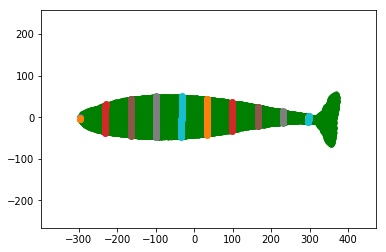

Image ID:  1
Current Whale's Girth [1.9999999999999993, 45.71603229007814, 61.0076822841732, 66.10517201182805, 61.0076822841732, 55.91030419296653, 43.747189471768046, 30.60290866722322, 20.413121085310152, 6.13548346399945]


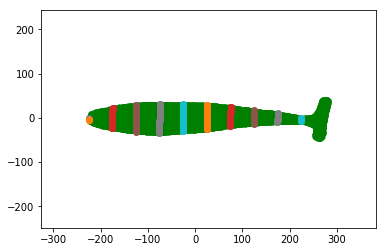

Image ID:  2
Current Whale's Girth [0.0, 68.15582512279686, 86.35220779187999, 88.53240845803701, 83.4381787263116, 76.16417726530862, 61.853313202284234, 43.18425766660403, 24.75733983985524, 8.067493898815936]


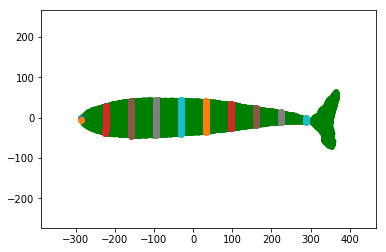

Image ID:  3
Current Whale's Girth [5.118439646779546, 63.151333732393105, 88.28785084398821, 99.46746890241813, 96.51406254734862, 85.3344493954955, 65.12008505360397, 42.588050062543964, 26.492238969537503, 16.30790420976431]


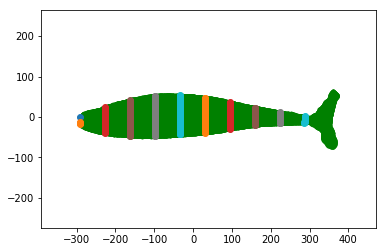

Image ID:  4
Current Whale's Girth [9.999999999999996, 58.08577668322695, 73.06576189668006, 79.10730753038564, 76.11120889790585, 71.11791475882873, 58.08577668322695, 37.06677630774009, 24.09018928655075, 14.064379853466376]


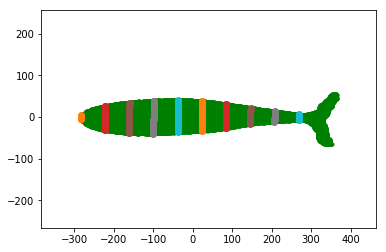

Image ID:  5
Current Whale's Girth [3.0000000000000004, 56.01557139949661, 69.00976791676295, 75.03310411085414, 76.0326832751965, 71.03481136851553, 59.04022880351656, 43.02249445949472, 26.035399003160478, 15.0]


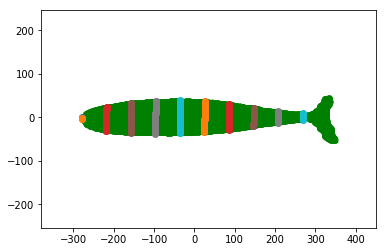

Image ID:  6
Current Whale's Girth [4.999999999999996, 80.3104667196789, 89.36359912670652, 91.3552177406177, 89.36359912670652, 80.4013802452311, 64.28707636425017, 44.19102079091338, 27.08540825364448, 15.146970812159845]


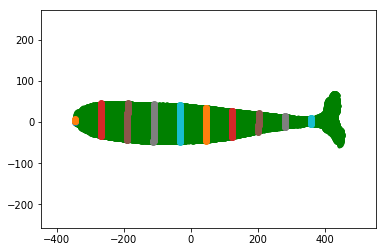

Image ID:  7
Current Whale's Girth [0.0, 54.04573274322321, 68.07042440615335, 68.03553783313833, 63.038993204813984, 55.01007883056334, 45.052975306028415, 32.02993210084442, 20.045929953596726, 7.999999999999999]


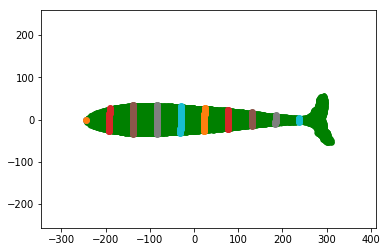

Image ID:  8
Current Whale's Girth [13.000000000000004, 53.04649845705991, 68.07139106965518, 70.0326892655733, 66.03580615306228, 60.041150368820226, 48.013673417582126, 36.02515760780867, 23.04136870508108, 6.000000000000001]


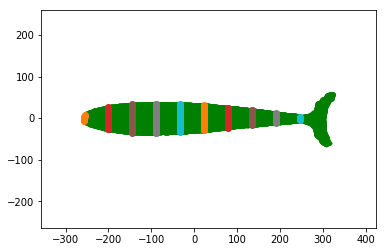

Image ID:  9
Current Whale's Girth [11.999999999999998, 49.01929634451871, 62.013100481695915, 65.03729345992531, 59.039968490071736, 52.01777652750341, 45.02143847289296, 36.02695635041079, 30.03151145594047, 15.999999999999998]


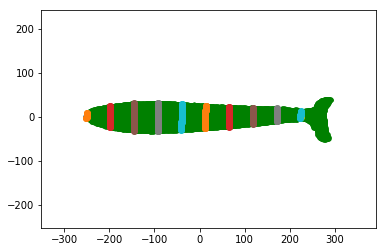

Image ID:  10
Current Whale's Girth [5.116289924612667, 61.98926264836533, 76.30145033577769, 80.41744340328007, 70.22076662271493, 61.989262648365326, 50.81075326595846, 36.49965103938084, 21.40011770247248, 4.192568694640531]


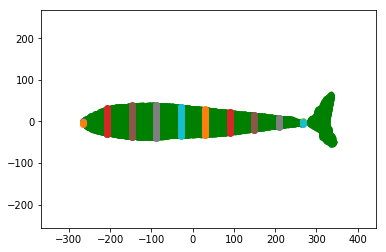

Image ID:  11
Current Whale's Girth [3.0000000000000084, 57.71202805465915, 74.97212026403581, 72.99985890329035, 69.05536661201742, 64.94549797842392, 51.795686629893005, 35.52420688638483, 21.395717427055143, 14.172762445695046]


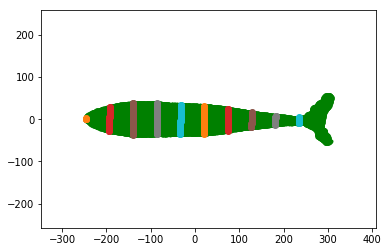

Image ID:  12
Current Whale's Girth [6.0, 56.017278593152234, 72.01198809054453, 75.01108639454291, 70.01260189271505, 63.01484522829818, 50.01957603675268, 37.025694799099405, 24.0, 12.000000000000002]


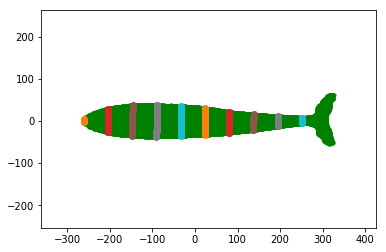

Image ID:  13
Current Whale's Girth [2.9999999999999996, 62.13629848406715, 79.1640274102593, 85.15229975909227, 87.14842183370922, 84.15424101620299, 70.18182187212588, 49.101427357196776, 27.026833954610815, 10.086066459720996]


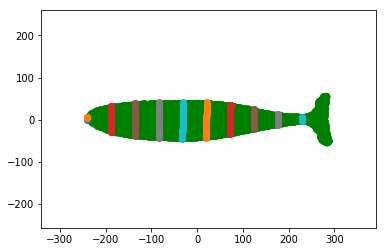

Image ID:  14
Current Whale's Girth [4.4967714020949145, 18.80766681854432, 20.14551176595675, 32.64965543462902, 46.96644278824777, 55.467982740316586, 66.64660338740758, 75.5896207704522, 75.58981339757779, 73.35399114067648, 59.938415545276435]


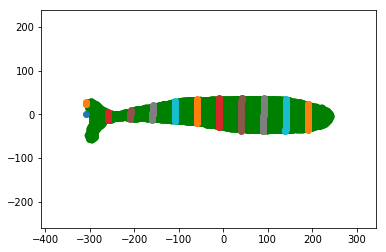

Image ID:  15
Current Whale's Girth [2.9999999999999987, 58.04252407492293, 67.03504499941361, 66.03576705535477, 64.03750312365825, 59.04157120736004, 49.05028680450447, 36.02498576167582, 23.041413197161276, 10.0]


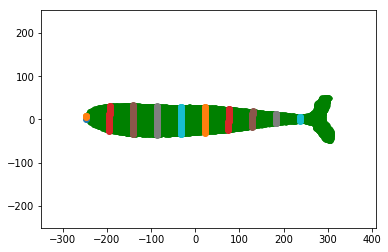

Image ID:  16
Current Whale's Girth [7.086148225964418, 60.67444840723135, 75.95982342669409, 72.9994122823766, 65.76931351101375, 54.753395160262734, 44.72423663369438, 37.49631149871077, 29.442435595702847, 22.218047100516397]


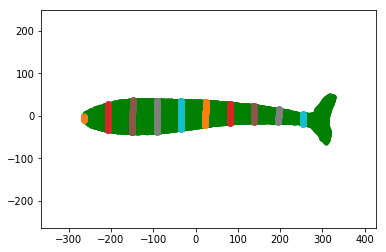

In [16]:
print("girth")
cnn_girths = girth(detection_results, cnn_lengths, 10)